In [32]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
%matplotlib inline

In [33]:
sns.set_theme(style="darkgrid", palette=sns.mpl_palette("viridis"))

In [34]:
input_file = r"tiny_eeg_self_experiment_reading_music.xls"

In [35]:
excelFile = pd.read_excel(input_file, sheet_name=["Music","Reading"])

df_music = excelFile["Music"]
df_reading = excelFile["Reading"]

In [36]:
print("=========== MUSIC INFO ===========")
print(df_music.info())
print("=========== READING INFO ===========")
print(df_reading.info())

=========== MUSIC INFO ===========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16383 entries, 0 to 16382
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IndexId   16383 non-null  int64  
 1   Channel1  16383 non-null  float64
 2   Channel2  16383 non-null  float64
 3   Channel3  16383 non-null  float64
 4   Channel4  16383 non-null  float64
 5   Ref1      16383 non-null  int64  
 6   Ref2      16383 non-null  int64  
 7   Ref3      16383 non-null  int64  
 8   TS1       16383 non-null  object 
 9   TS2       16383 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.3+ MB
None
=========== READING INFO ===========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16383 entries, 0 to 16382
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IndexId   16383 non-null  int64  
 1   Channel1  16383 non-null  float64
 2   Channel2  1638


## Limpieza de datos

### Dataset Musica

In [37]:
df_music = df_music.drop(labels=["IndexId","Ref1","Ref2","Ref3","TS1","TS2"],axis=1)
df_music.head()

,Channel1,Channel2,Channel3,Channel4
0,933.19,519.23,21.71,238.45
1,932.94,516.98,22.70,251.80
2,827.70,521.87,17.26,207.42
3,893.26,519.82,18.90,219.49
4,953.94,520.69,21.88,252.06


In [38]:
len(df_music)

16383

In [39]:
def plot_channels(channels, t,title):
    fig, axs = plt.subplots(2,2,figsize=(14,10))

    ((ax1,ax2),(ax3,ax4)) = axs
    axs = [ax1,ax2,ax3,ax4]
    for channel, ax in zip(channels, axs):
        ax.plot(t, channel)
        ax.set_title(f"{channel.name}")

    fig.supxlabel("Tiempo [s]")
    fig.supylabel(r"Amplitud [$\mu$Vrms]")

    fig.suptitle(title)
    plt.show()

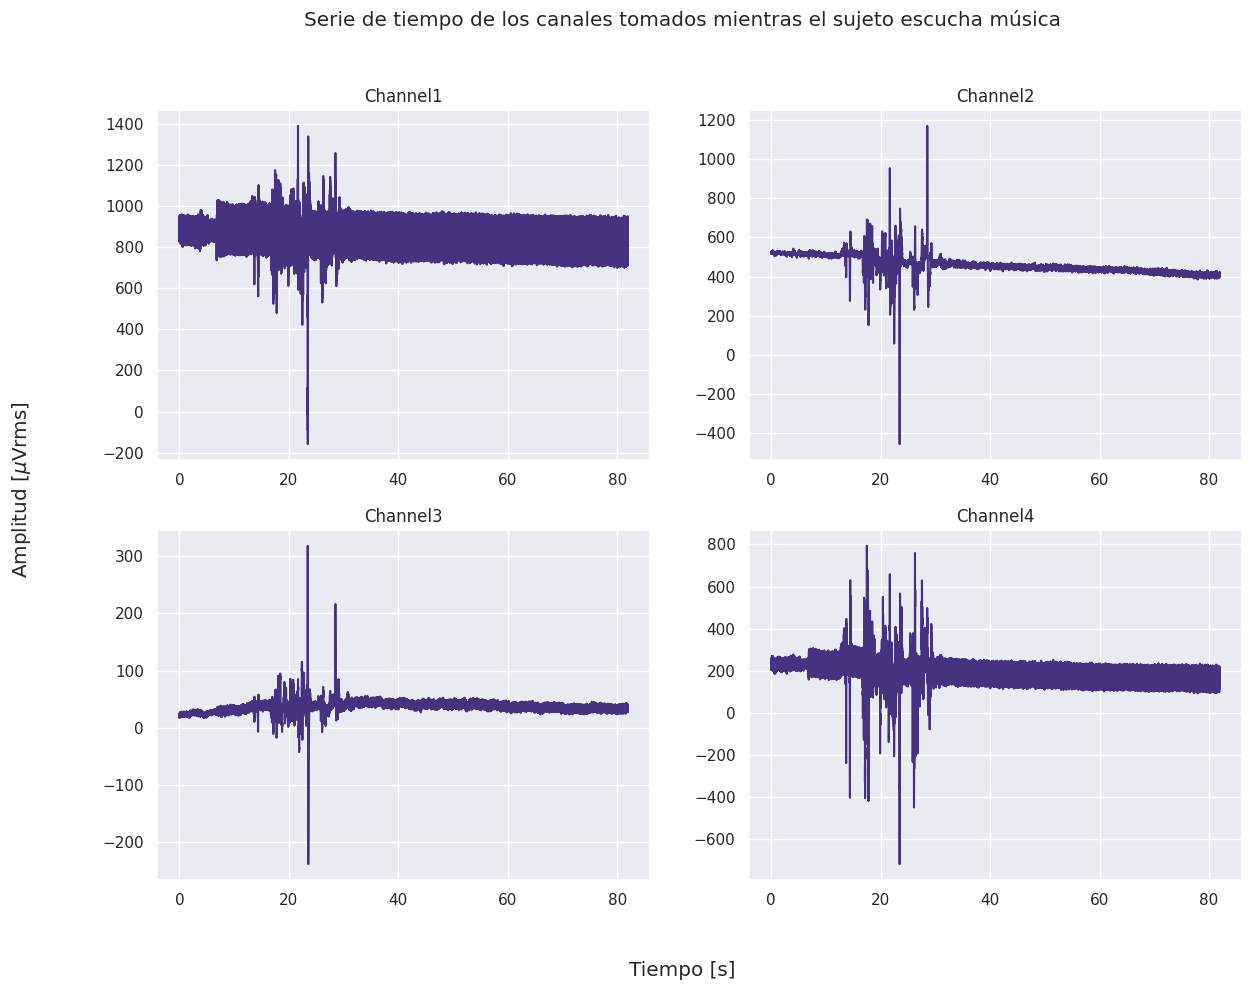

In [40]:
#sampling rate del ganglion board es de 200 Hz
fs = 200
T_mus = 1/fs * len(df_music)
t_mus = np.linspace(0,T_mus,len(df_music))
T_read = 1 / fs * len(df_reading)
t_read = np.linspace(0,T_read,len(df_reading))


channels = [df_music[f"Channel{i}"] for i in range(1,5)]
plot_channels(channels=channels, t=t_mus,title="Serie de tiempo de los canales tomados mientras el sujeto escucha música")

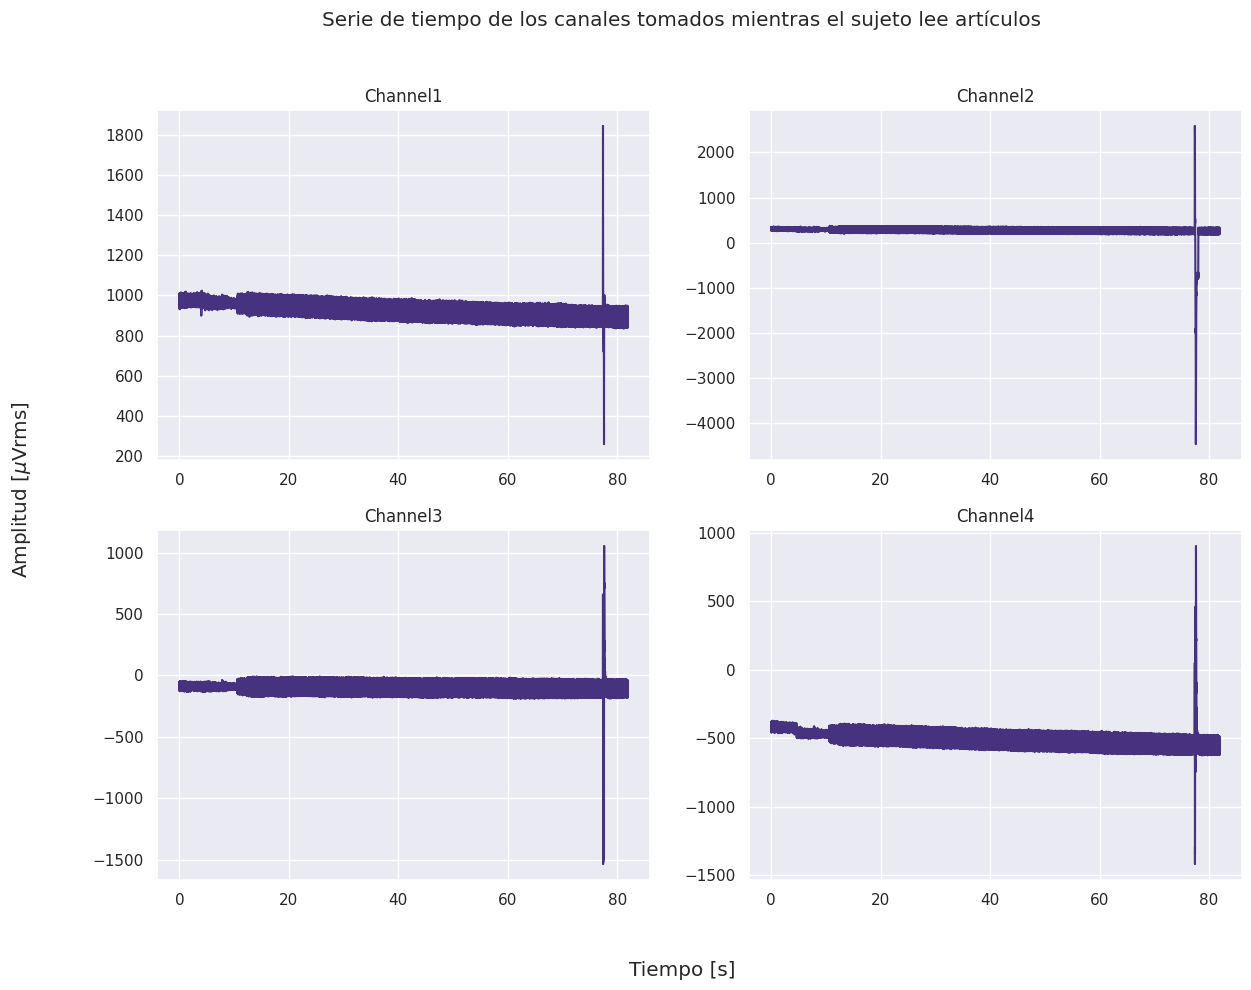

In [41]:
channels = [df_reading[f"Channel{i}"] for i in range(1,5)]
plot_channels(channels=channels, t= t_read, title="Serie de tiempo de los canales tomados mientras el sujeto lee artículos")

#### Usando Wavelets

### Dataset música

In [42]:
channels_mus = [df_music[f"Channel{i}"] for i in range(1,5)]
channels_read = [df_reading[f"Channel{i}"] for i in range(1,5)]

In [43]:
def get_coefs(channels):
    coefs = {}

    for i in range(len(channels)):
        coefs[f"CH{i+1}"] = pywt.wavedec(channels[i], 'db8', mode = 'periodic',level=8)

    return coefs

In [44]:
#Obtener coeficientes
coef_mus = get_coefs(channels_mus)
coef_read = get_coefs(channels_read)
len(coef_mus["CH1"])

9

In [45]:
len(coef_read["CH1"])

9

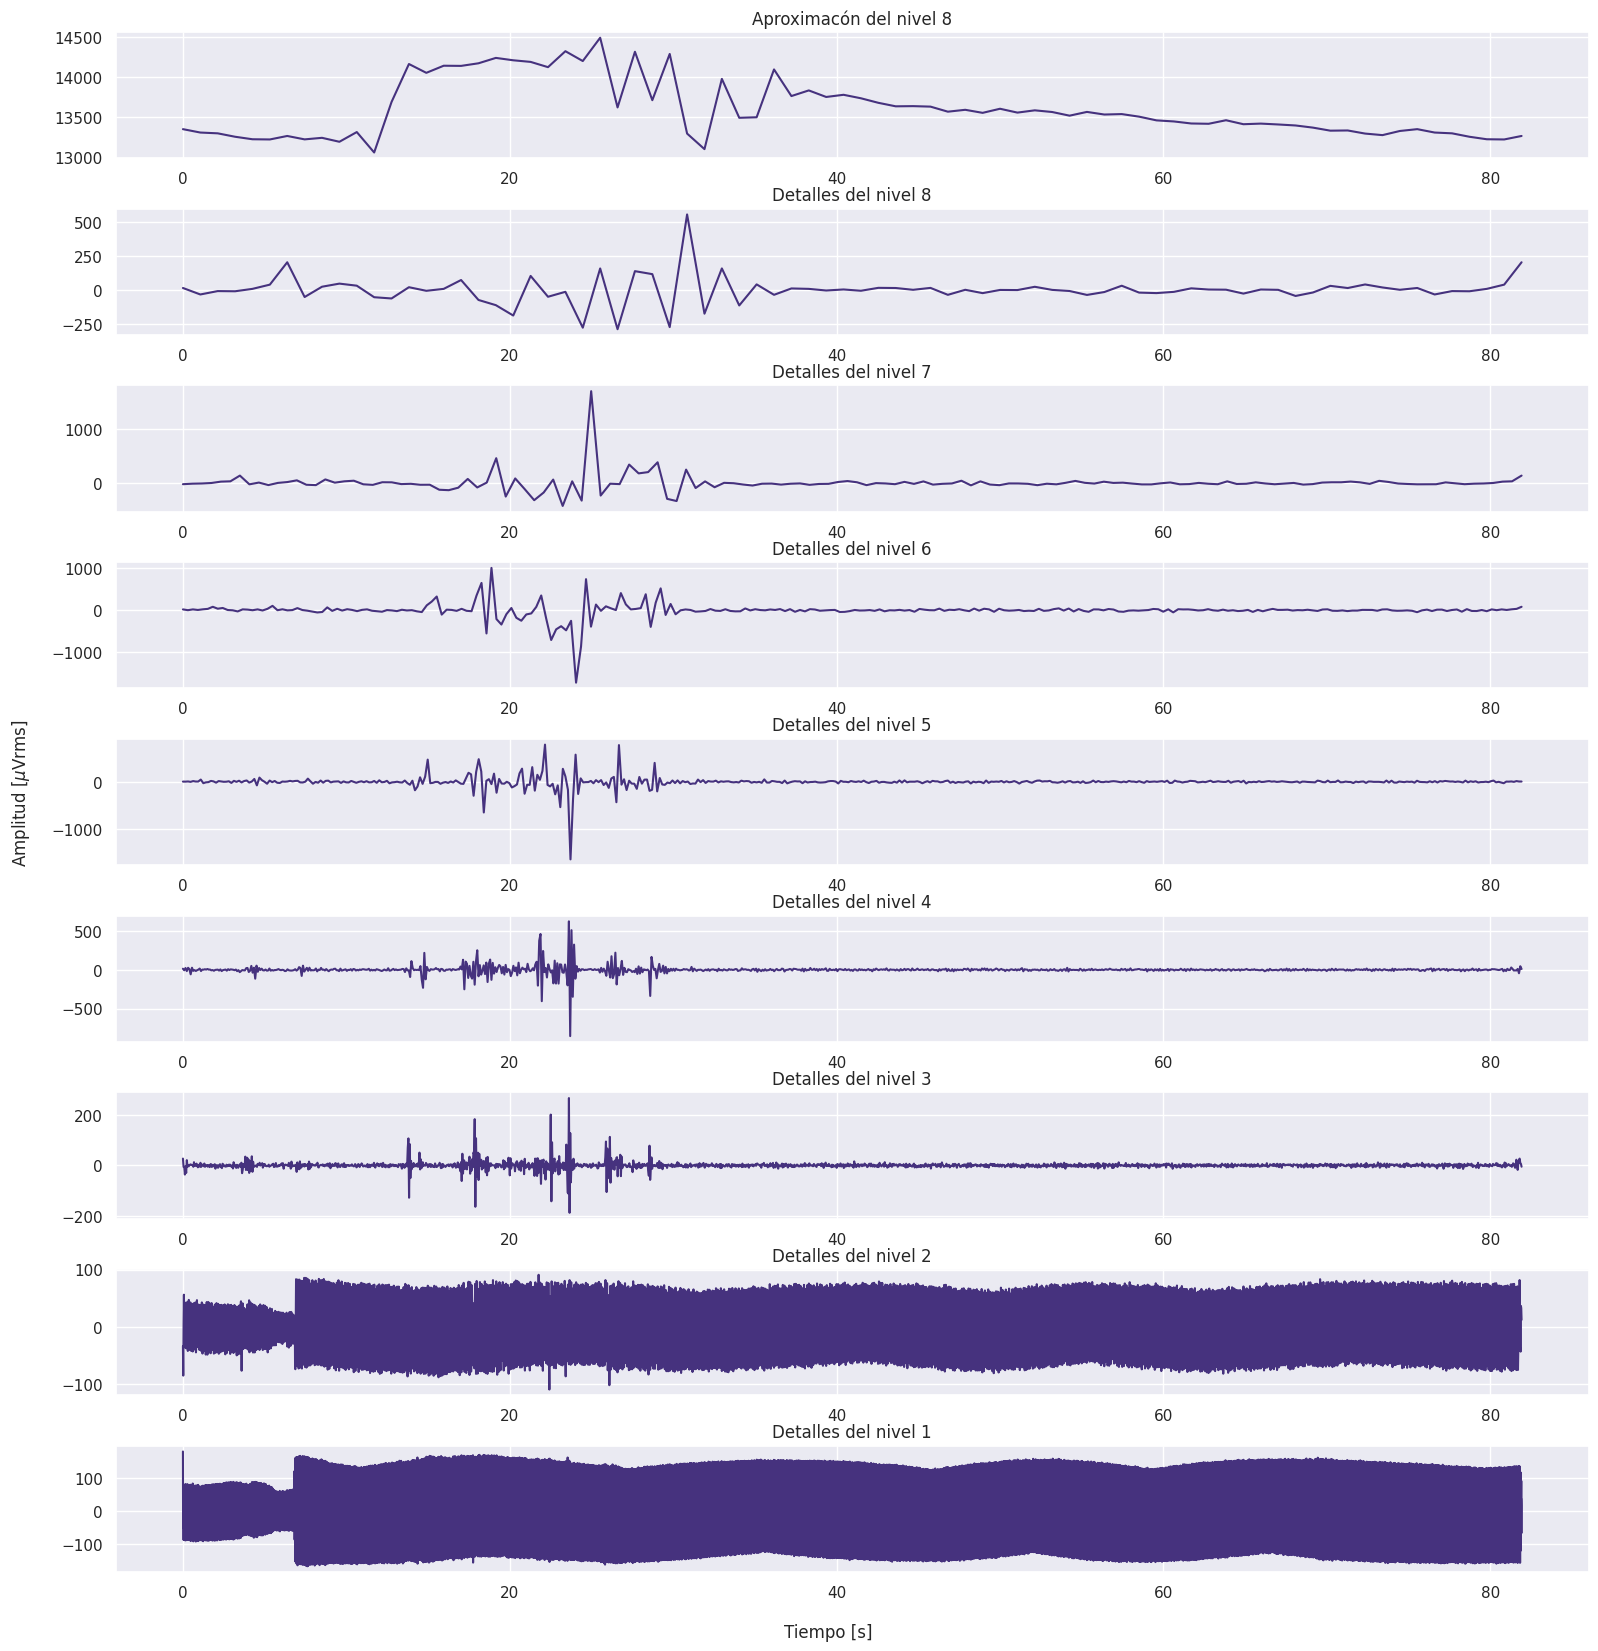

In [46]:
def plot_coefs(coef_channel,t_max):
  t = []
  for detap in coef_channel:
    t.append(np.linspace(0,t_max,len(detap)))

  fig, axs = plt.subplots(len(coef_channel),1, figsize=(19,20))

  for i in range(len(coef_channel)):
      axs[i].plot(t[i],coef_channel[i])
      if i == 0:
        axs[i].set_title(f"Aproximacón del nivel {len(coef_channel)-1}")
      elif i == 1:
        axs[i].set_title(f"Detalles del nivel {len(coef_channel)-1}")
      else:
        axs[i].set_title(f"Detalles del nivel {len(coef_channel)-i}")

  fig.text(0.5, 0.08, 'Tiempo [s]', ha='center', va='center')
  fig.text(0.075, 0.5, r'Amplitud [$\mu$Vrms]', ha='center', va='center', rotation='vertical')


  plt.subplots_adjust(hspace=0.4)
  plt.show()
plot_coefs(coef_mus["CH1"],T_mus)

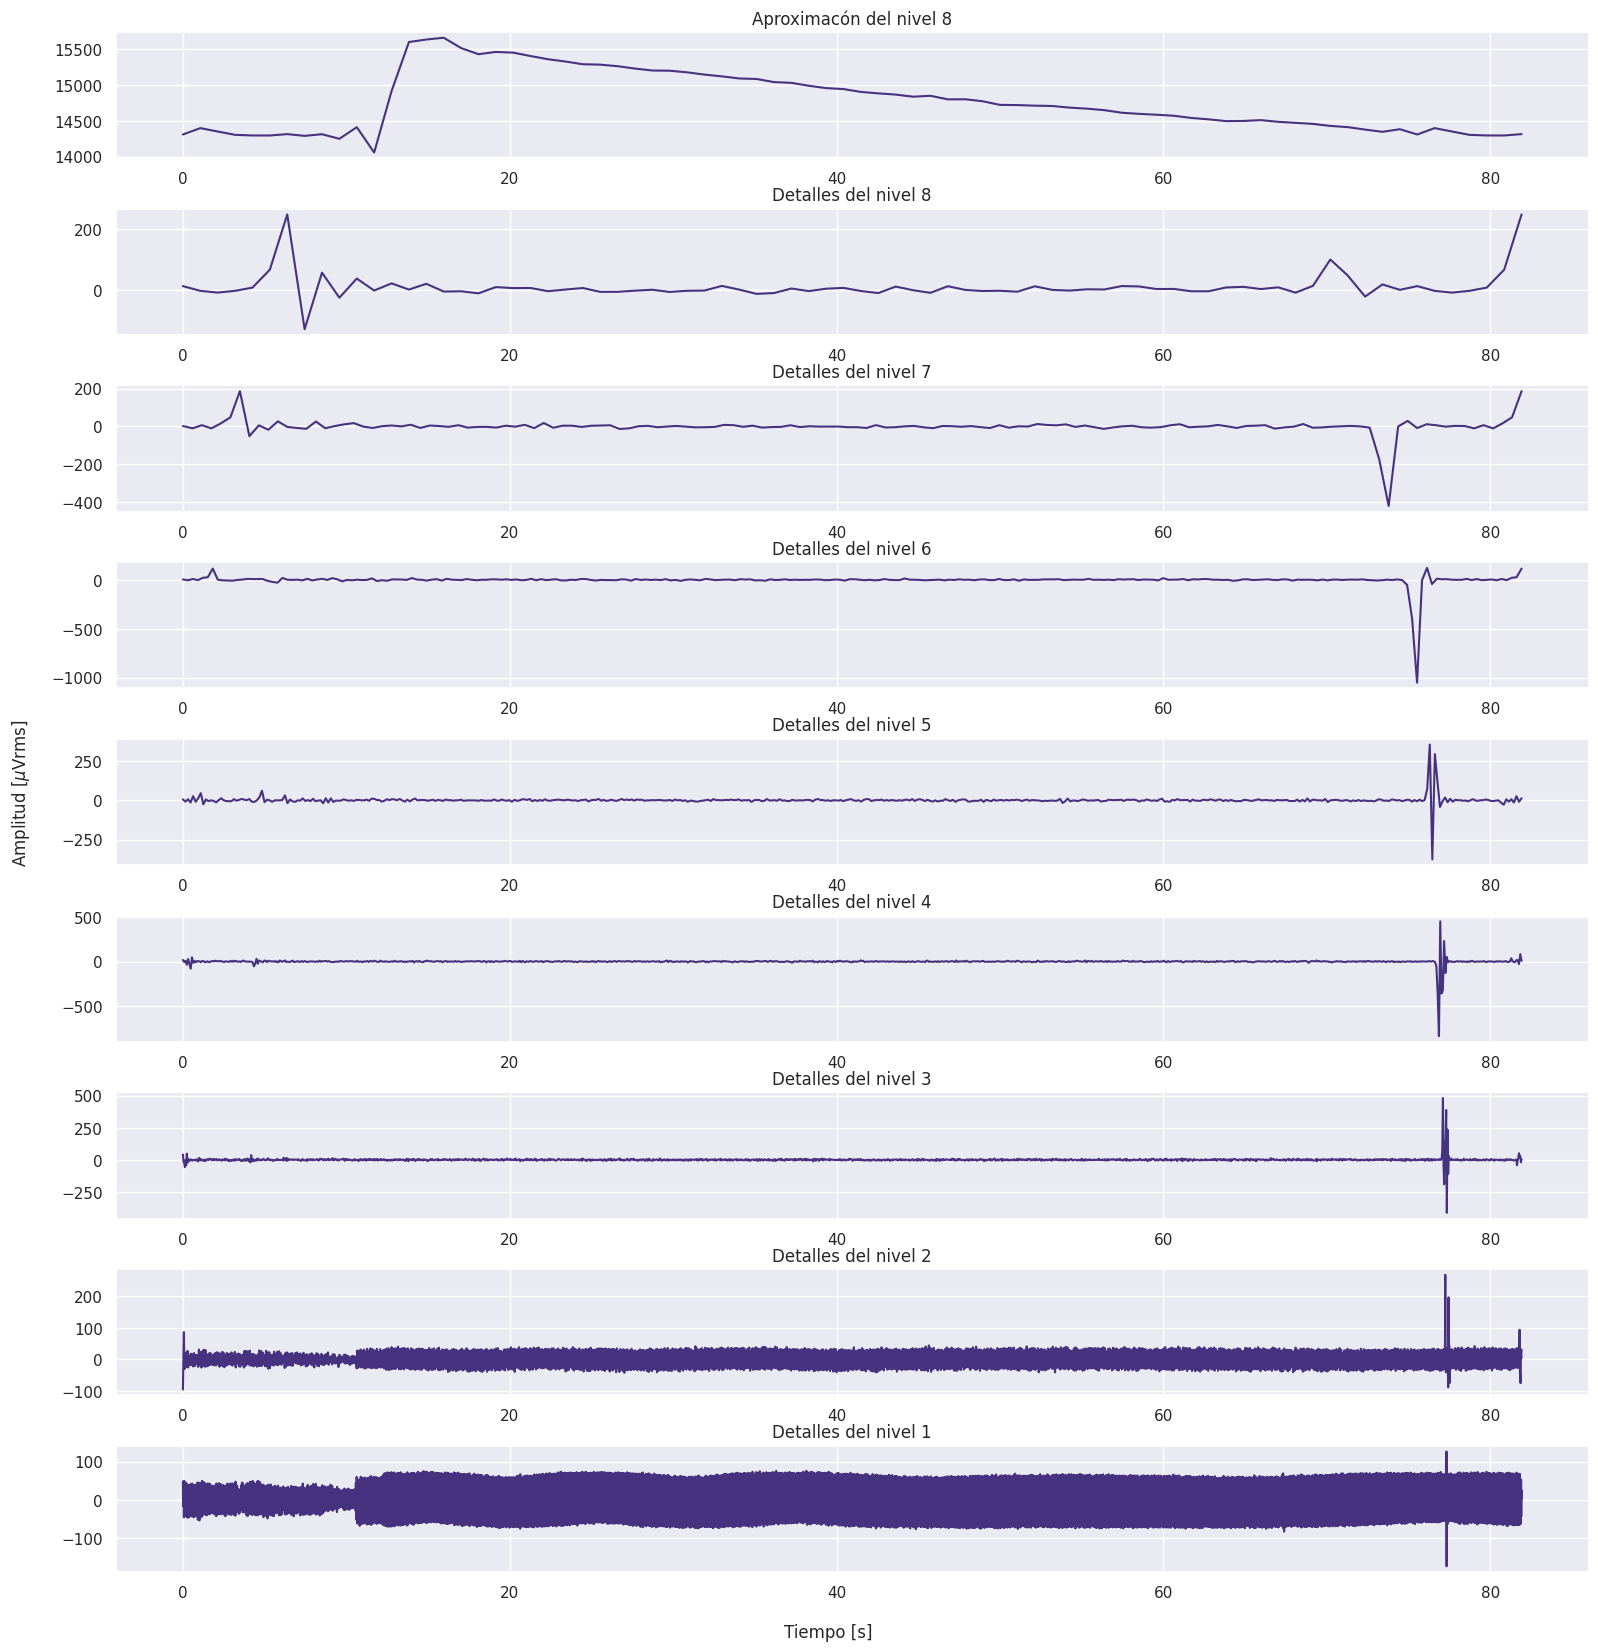

In [47]:
plot_coefs(coef_channel=coef_read["CH1"], t_max=T_read)

In [48]:
def remove_appdet(coefs):
    for channel in coefs:
        coefs[channel] = coefs[channel][1:7]

In [49]:
# De cada canal solo nos interesan los detalles D8 a D3
remove_appdet(coef_mus)
remove_appdet(coef_read)


In [50]:
#Tresholding universal
from statsmodels.robust import mad

def get_treshs(coefs,sigsize):

    threshs = {}
    for channel in coefs:

        sigma = mad(coefs[channel][-1])#variable coefs_ruido debe ser reemplazada por su variable
        tres_val = sigma * np.sqrt(2 * np.log(sigsize))
        treshs = [pywt.threshold(da,tres_val,mode='soft') for da in coefs[channel]]
        threshs[channel] = treshs
    
    return threshs

In [51]:
coef_mus_clean = get_treshs(coef_mus, len(df_music))
coef_read_clean = get_treshs(coef_read, len(df_reading))

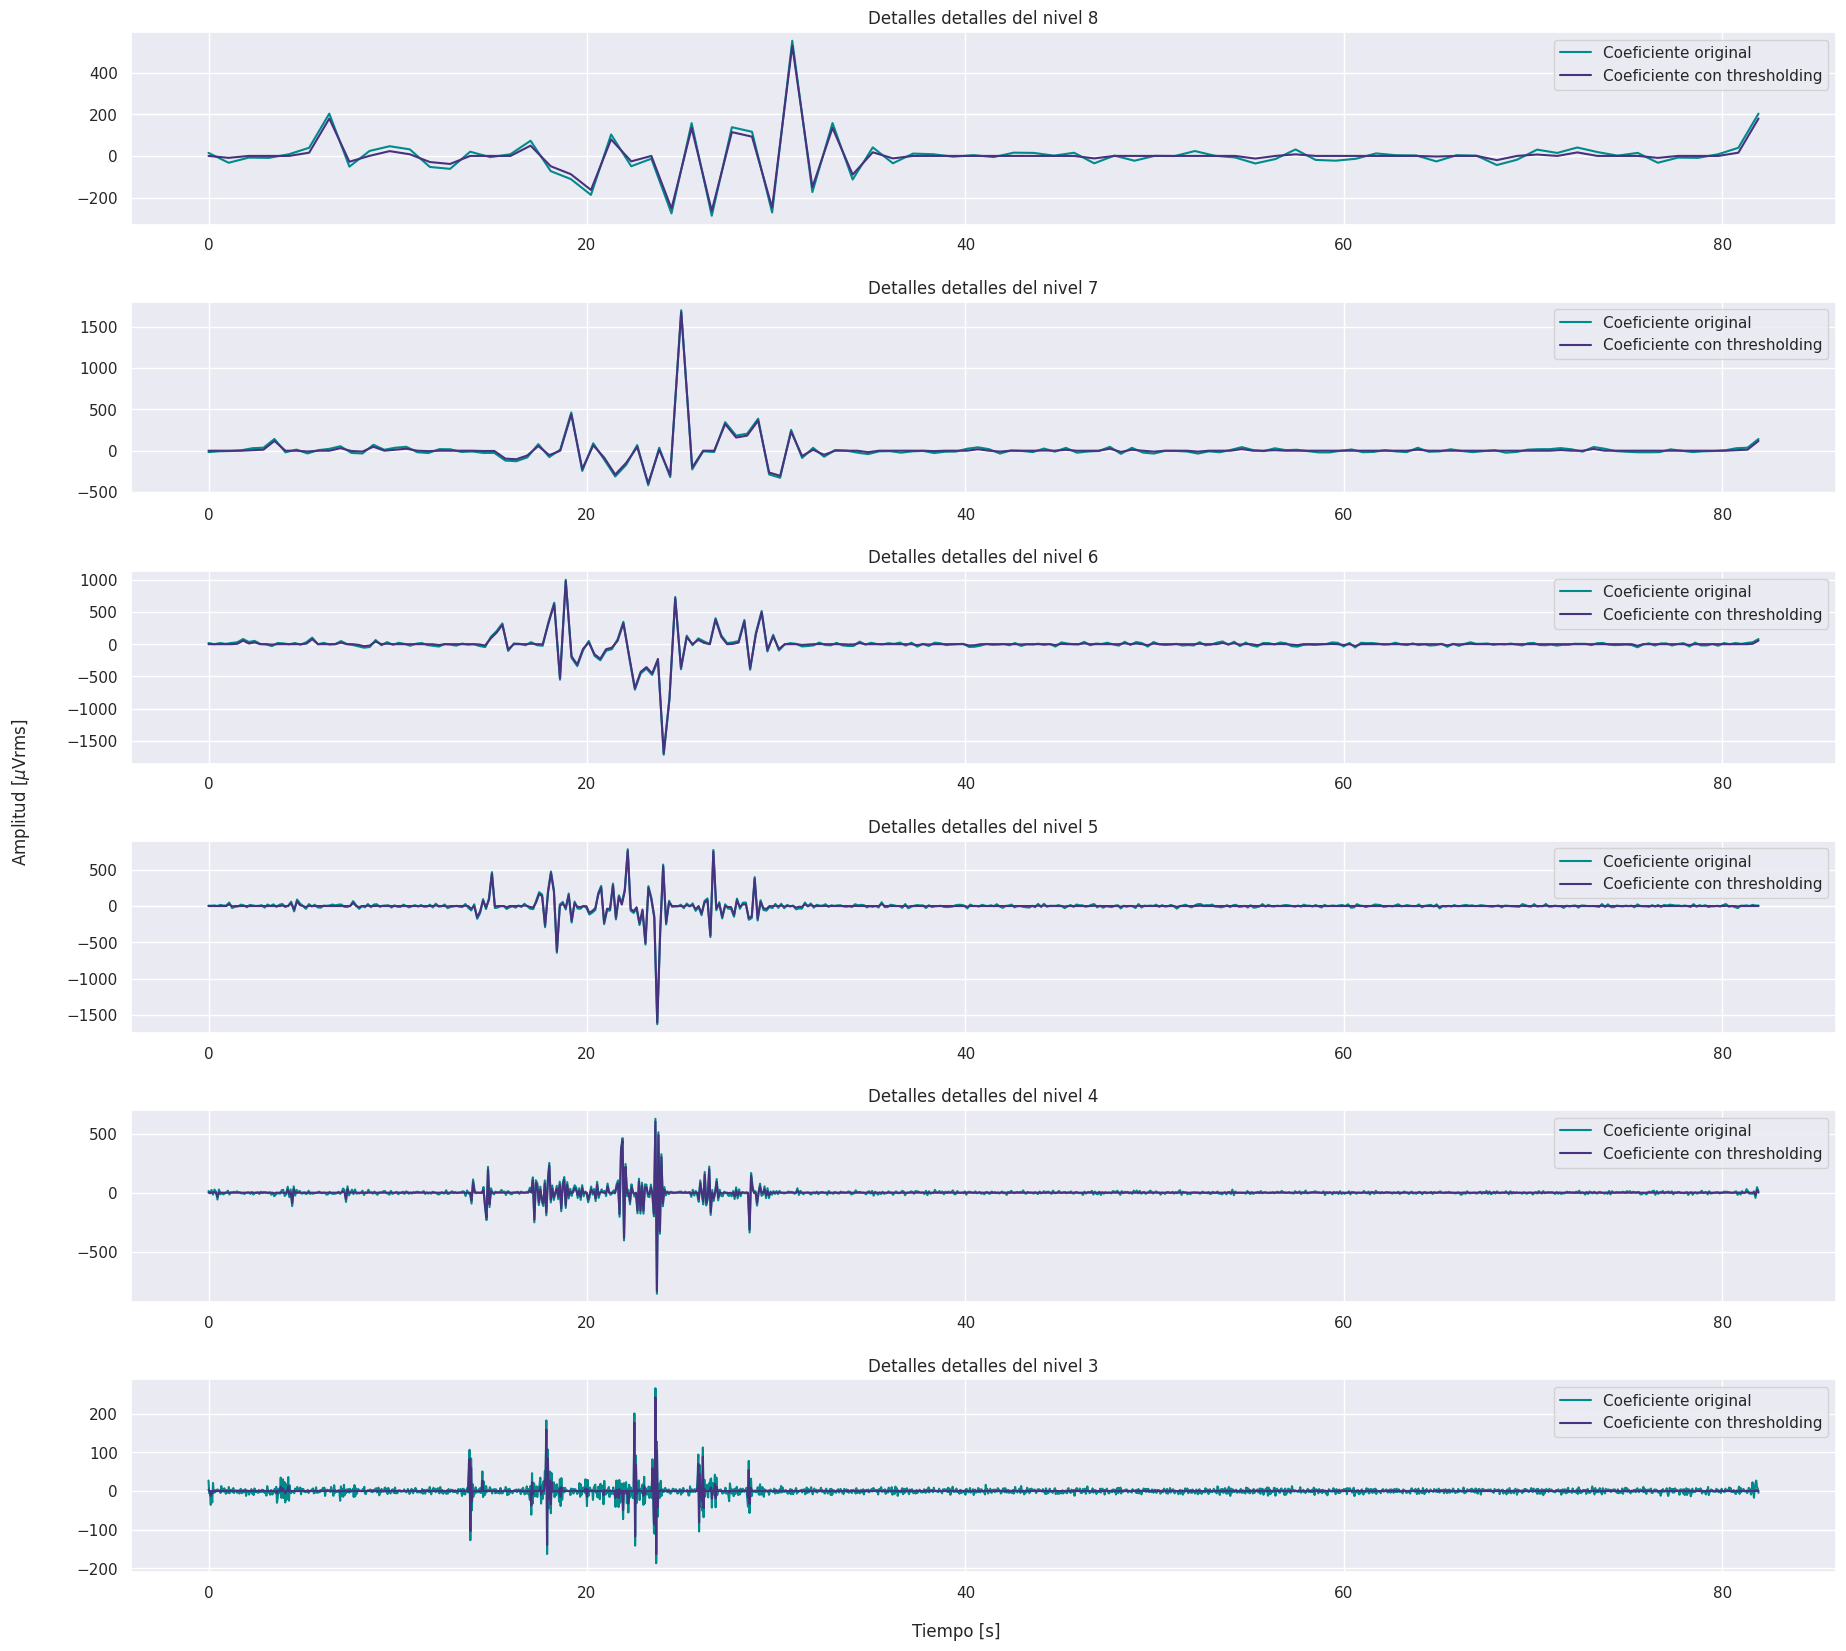

In [52]:
t = []
for detap in coef_mus_clean["CH1"]:
  t.append(np.linspace(0,T_mus,len(detap)))

n = len(coef_mus_clean["CH1"])
fig, axs = plt.subplots(n,1, figsize=(22,20))
for i in range(n):
    axs[i].plot(t[i], coef_mus["CH1"][i], color= 'darkcyan', label="Coeficiente original")
    axs[i].plot(t[i],coef_mus_clean["CH1"][i],label="Coeficiente con thresholding")
    axs[i].legend()
    axs[i].set_title(f"Detalles detalles del nivel {n+2-i}")

fig.subplots_adjust(hspace=0.4)

fig.text(0.5, 0.08, 'Tiempo [s]', ha='center', va='center')
fig.text(0.075, 0.5, r'Amplitud [$\mu$Vrms]', ha='center', va='center', rotation='vertical')

plt.show()

In [53]:
coef_mus = coef_mus_clean
coef_read = coef_read_clean

In [54]:
# Calculamos la energía de los canales,según el teorema de parseval:
def get_energyleveldist(coefs):

    ED = []
    for channel in coefs:
        e = [np.sum(np.abs(level)**2) for level in coefs[channel]]
        ED.append(e)
    
    max_ED = np.max(ED)

    for channel in ED:
        channel /= max_ED

    
    return np.array(ED)

In [55]:
def plot_energylevels(ED):
    channels = [f'CH{i}' for i in range(1,5)]
    levels = [f'D{8-i}' for i in range(6)]
    
    # Crear una figura y ejes
    fig, ax = plt.subplots(figsize=(14, 8))

    # Posiciones para los grupos de barras
    bar_width = 0.2
    positions = np.arange(len(levels))

    # Plotear barras para cada canal
    for i, channel in enumerate(channels):
        energy_levels = ED[i]
        bar_positions = positions + i * bar_width
        ax.bar(bar_positions, energy_levels, bar_width, label=channel)
        ax.set_yscale('log')

    # Ajustes de la gráfica
    ax.set_xlabel('Distribución de energía')
    ax.set_ylabel(r'$\log$(Energía [%])')
    ax.set_title('Distribución de energía por canal en escala logarítmica')
    ax.set_xticks(positions + bar_width * (len(channels) - 1) / 2)
    ax.set_xticklabels(levels)
    ax.legend()

    plt.show()

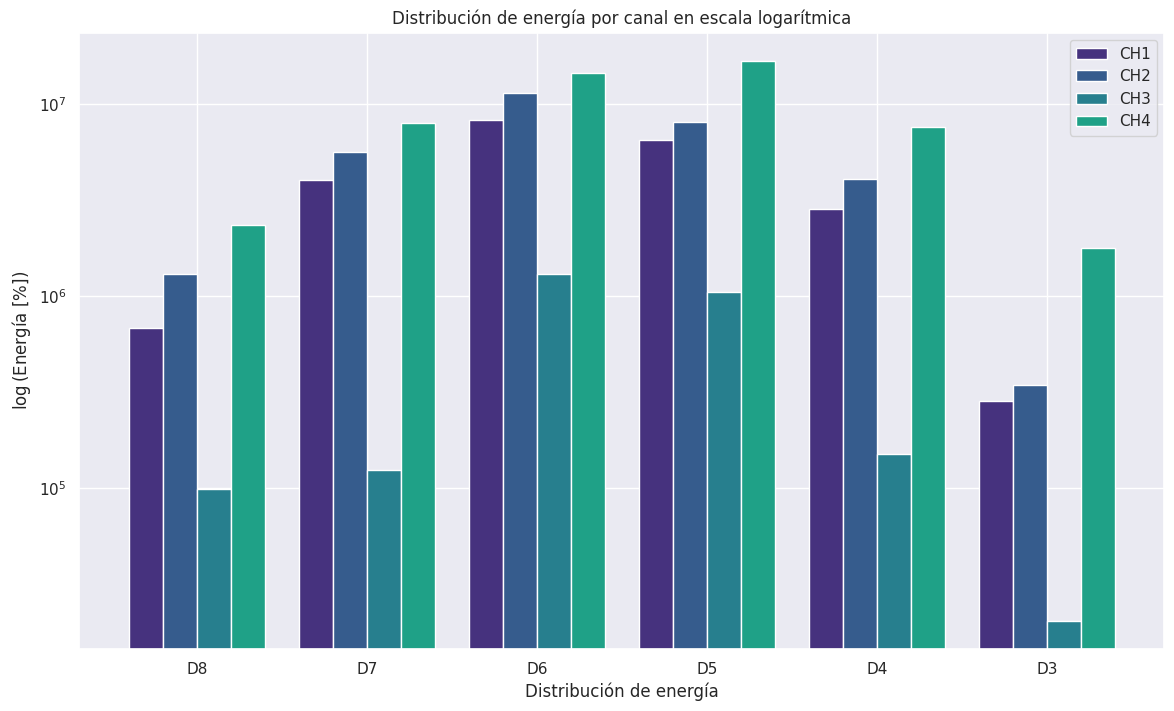

In [56]:
ED_mus = get_energyleveldist(coef_mus)
plot_energylevels(ED_mus)

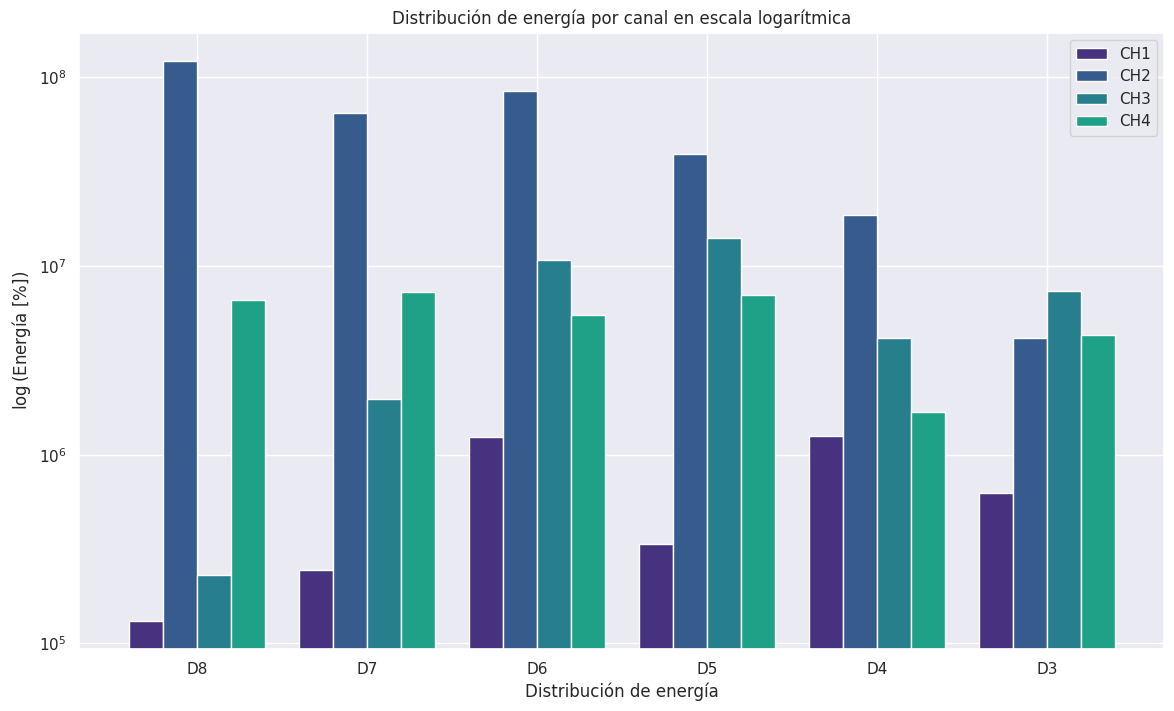

In [57]:
ED_read = get_energyleveldist(coef_read)
plot_energylevels(ED_read)

In [58]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from mpl_toolkits.mplot3d import Axes3D


In [59]:
labels_reading = np.zeros(len(ED_read))
labels_music = np.ones(len(ED_mus))

In [60]:
X = np.vstack((ED_read,ED_mus))
y = np.hstack((labels_reading, labels_music))

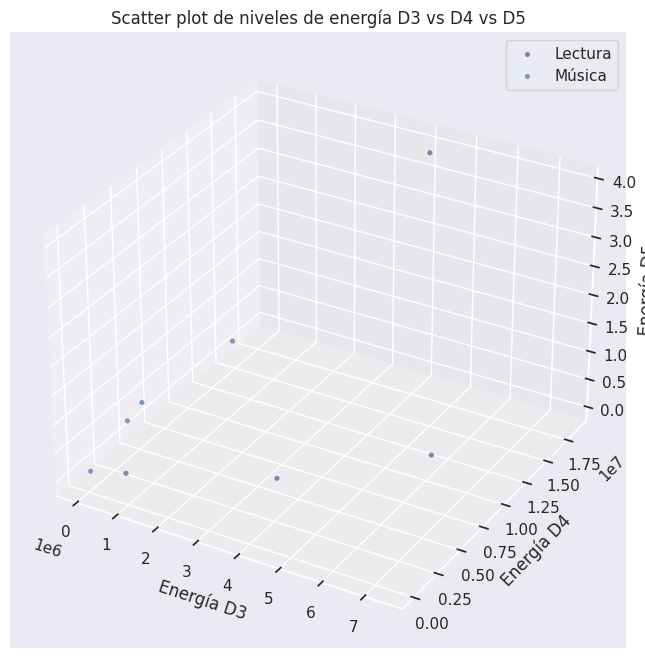

In [61]:
# Scatter plot de tres niveles de energía (ejemplo D3 vs D4 vs D5)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[y==0, 5], X[y==0, 4], X[y==0, 3], label='Lectura', alpha=0.6, edgecolors='w')
ax.scatter(X[y==1, 5], X[y==1, 4], X[y==1, 3], label='Música', alpha=0.6, edgecolors='w')
ax.set_xlabel('Energía D3')
ax.set_ylabel('Energía D4')
ax.set_zlabel('Energía D5')
ax.set_title('Scatter plot de niveles de energía D3 vs D4 vs D5')
plt.legend()
plt.show()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Kernel: {kernel}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("-" * 60)

Kernel: linear
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         2
         1.0       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3

------------------------------------------------------------
Kernel: poly
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         2
         1.0       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3

------------------------------------------------------------
Kernel: rbf
Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.0

/home/schrodincris/semestre/2024-1/sigproc/proyecto/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/schrodincris/semestre/2024-1/sigproc/proyecto/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/schrodincris/semestre/2024-1/sigproc/proyecto/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont